# RNNs - Recurrent Neural Networks

In [490]:
from typing import List, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, SimpleRNN, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping

First we will generate a simple synthetic Dataset:

In [374]:
omega = 8
size = 800
A = 1
Anoise = 0.2
t = np.linspace(0, 2*np.pi, size)
series = A*np.sin(omega*t) + Anoise*np.random.randn(size)

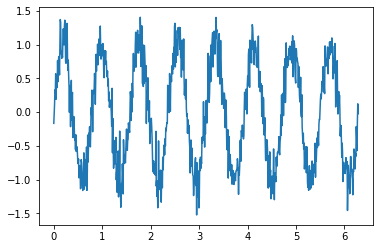

In [375]:
plt.plot(t, series)

Next, to be able to feed the Data into the network we need to create input vectors from the time series. In order to do this, first we generate the following function:

In [376]:
def sequence_to_vectors(
    series: Union[np.ndarray, pd.Series], 
    time_dim: int, 
    output_dim: int = 1,
    prefix: str = 'x',
    target_name: Union[List[str], str] = 'target') -> Union[pd.DataFrame, Tuple[pd.DataFrame, pd.Series]]:
        """
        Generates feature vectors from sequence data. Generates both input time feature vector and target feature vector.
        In case the output dimension is zero, no target will be provided. In case it is greater than one, the parameter
        target_name will be treated as the prefix in case it is provided as a string.
        """

        if isinstance(target_name, list):
            if len(target_name) != output_dim:
                raise IndexError('Output dimension and target name list length do not match.')

        total_dim = time_dim + output_dim

        target_name = [] if output_dim == 0 else target_name
        if output_dim >= 1:
            if isinstance(target_name, str):
                target_name = [f'{target_name}{j}' if output_dim != 1 else target_name for j in range(output_dim)]

        col_names = [f'{prefix}{j}' for j in range(time_dim)] + target_name

        data = pd.DataFrame([], columns=col_names)
        for i in range(series.size - total_dim + 1):
            data = data.append(pd.Series(series[i:i + total_dim], index=col_names, name=i))

        if output_dim:
            X, y = data[col_names[:-output_dim]], data[target_name]
            return X, y
        else:
            X = data
            return X


Now, applying the function we have:

In [465]:
T = 20 #Time Dimension
K = 5 #Output Dimension
D = 1 #Feature Input dimension
M = 5 #Hidden layer number of units

X, y = sequence_to_vectors(
    series=series, 
    time_dim=T,
    output_dim=K,
)

X.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19
0,-0.165523,-0.028423,0.114547,0.329584,0.285475,0.568942,0.191618,0.538848,0.360681,0.435776,0.765714,0.450824,0.705947,0.825626,0.716731,0.552003,0.956341,1.372473,1.332949,0.865451
1,-0.028423,0.114547,0.329584,0.285475,0.568942,0.191618,0.538848,0.360681,0.435776,0.765714,0.450824,0.705947,0.825626,0.716731,0.552003,0.956341,1.372473,1.332949,0.865451,0.908359
2,0.114547,0.329584,0.285475,0.568942,0.191618,0.538848,0.360681,0.435776,0.765714,0.450824,0.705947,0.825626,0.716731,0.552003,0.956341,1.372473,1.332949,0.865451,0.908359,0.798051
3,0.329584,0.285475,0.568942,0.191618,0.538848,0.360681,0.435776,0.765714,0.450824,0.705947,0.825626,0.716731,0.552003,0.956341,1.372473,1.332949,0.865451,0.908359,0.798051,0.846449
4,0.285475,0.568942,0.191618,0.538848,0.360681,0.435776,0.765714,0.450824,0.705947,0.825626,0.716731,0.552003,0.956341,1.372473,1.332949,0.865451,0.908359,0.798051,0.846449,0.812487


As we can see, we can specify both the time dimension of the feature vectors and the target output dimension (the prediction horizon), by simply changing the function parameters. Now let's proceed to making the prediction code.

In [484]:
M = 8 #Hidden layer number of units

i = Input(shape=(T, D))
# x = SimpleRNN(M, activation='tanh', return_sequences=True)(i)
# x = Dropout(0.2)(x)
x = SimpleRNN(M, activation='tanh')(i)
# x = Dropout(0.2)(x)
x = Dense(K)(x)
model = Model(i, x)

model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.05)
)

r = model.fit(
    X[:size//2].values.reshape(-1, T, D), y[:size//2],
    verbose=1,
    epochs=100,
    validation_data=(X[-size//2:].values.reshape(-1, T, D), y[-size//2:]),
    callbacks=[EarlyStopping(patience=20)]
)

Train on 400 samples, validate on 400 samples
Epoch 1/100
400/400 [==============================] - 3s 8ms/sample - loss: 0.2065 - val_loss: 0.0993
Epoch 2/100
400/400 [==============================] - 0s 198us/sample - loss: 0.1024 - val_loss: 0.0836
Epoch 3/100
400/400 [==============================] - 0s 218us/sample - loss: 0.0944 - val_loss: 0.0802
Epoch 4/100
400/400 [==============================] - 0s 174us/sample - loss: 0.0943 - val_loss: 0.0819
Epoch 5/100
400/400 [==============================] - 0s 165us/sample - loss: 0.0932 - val_loss: 0.0812
Epoch 6/100
400/400 [==============================] - 0s 159us/sample - loss: 0.0916 - val_loss: 0.0838
Epoch 7/100
400/400 [==============================] - 0s 167us/sample - loss: 0.0916 - val_loss: 0.0789
Epoch 8/100
400/400 [==============================] - 0s 158us/sample - loss: 0.0908 - val_loss: 0.0793
Epoch 9/100
400/400 [==============================] - 0s 171us/sample - loss: 0.0880 - val_loss: 0.0738
Epoch 10/10

In [485]:
model.summary()

Model: "model_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        [(None, 20, 1)]           0         
_________________________________________________________________
simple_rnn_88 (SimpleRNN)    (None, 8)                 80        
_________________________________________________________________
dense_67 (Dense)             (None, 5)                 45        
Total params: 125
Trainable params: 125
Non-trainable params: 0
_________________________________________________________________


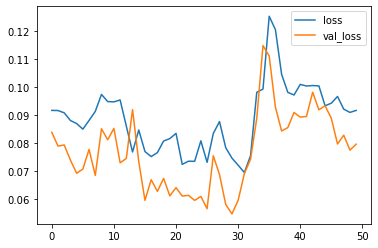

In [486]:
plt.plot(r.history['loss'][5:])
plt.plot(r.history['val_loss'][5:])
plt.legend(r.history.keys())

Text(0.5, 1.0, 'Wrong predictions')

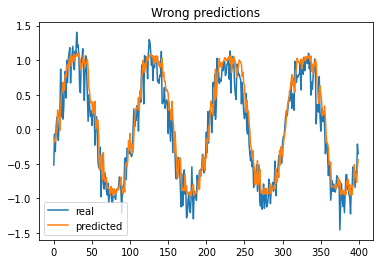

In [487]:
plt.plot(y.iloc[-size//2:,0].reset_index(drop=True))
plt.plot(list(model.predict(X[-size//2:].values.reshape(-1, T, D))[:,0]))
plt.legend(['real','predicted'])
plt.title('Wrong predictions')

In [488]:
x = X.iloc[-size//2:-size//2+1, :].values.reshape(-1, T, D)

forecast = []
for i in range(size//2):
    prediction = model.predict(x)[0][0]

    forecast.append(prediction)

    x = np.roll(x, shift=-1)
    x[0][-1][0] = prediction

Text(0.5, 1.0, 'Wrong predictions')

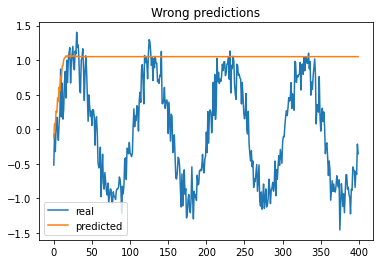

In [489]:
plt.plot(y.iloc[-size//2:,0].reset_index(drop=True))
plt.plot(forecast)
plt.legend(['real','predicted'])
plt.title('Wrong predictions')

# RNNs for image classification

In [491]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

11493376/11490434 [==============================] - 1s 0us/step


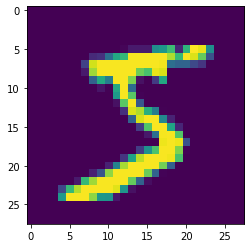

In [493]:
plt.imshow(x_train[0])

In [502]:
T = x_train[0].shape[0] #The Time Dimension is the number of rows of the matrix
D = x_train[0].shape[1] #The number of features is the number of columns
M = 128

i = Input(shape=(T, D))
x = LSTM(M)(i)
x = Dense(10, activation='softmax')(x)

model = Model(i, x)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.05),
    metrics=['accuracy']
)

r = model.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_test, y_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 155s 3ms/sample - loss: 1.2030 - acc: 0.5916 - val_loss: 0.7654 - val_acc: 0.7673
Epoch 2/10
60000/60000 [==============================] - 153s 3ms/sample - loss: 0.9618 - acc: 0.6853 - val_loss: 0.8094 - val_acc: 0.7430
Epoch 3/10
60000/60000 [==============================] - 159s 3ms/sample - loss: 0.9989 - acc: 0.6656 - val_loss: 0.8995 - val_acc: 0.6718
Epoch 4/10
60000/60000 [==============================] - 163s 3ms/sample - loss: 0.8129 - acc: 0.7215 - val_loss: 0.7748 - val_acc: 0.7202
Epoch 5/10
60000/60000 [==============================] - 157s 3ms/sample - loss: 0.7180 - acc: 0.7556 - val_loss: 0.7448 - val_acc: 0.7587
Epoch 6/10
60000/60000 [==============================] - 159s 3ms/sample - loss: 0.7460 - acc: 0.7543 - val_loss: 0.7466 - val_acc: 0.7509
Epoch 7/10
60000/60000 [==============================] - 159s 3ms/sample - loss: 0.7421 - acc: 0.7597 - val_l

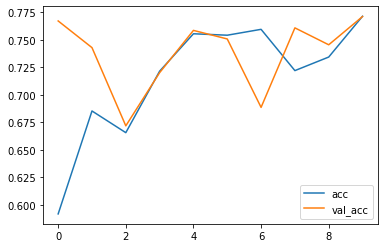

In [505]:
plt.plot(r.history['acc'])
plt.plot(r.history['val_acc'])
plt.legend(['acc','val_acc'])